# Wild Blueberry Yield Prediction

**Context**: The dataset used for predictive modeling was generated by the Wild Blueberry Pollination Simulation Model, which is an open-source, spatially-explicit computer simulation program that enables exploration of how various factors, including plant spatial arrangement, outcrossing and self-pollination, bee species compositions and weather conditions, in isolation and combination, affect pollination efficiency and yield of the wild blueberry agroecosystem.

**Goal**: Through the provided features predict the wild blueberry yield amount.

**Feature Description**:
- Clonesize: m2 The average blueberry clone size in the field
- Honeybee: bees/m2/min Honeybee density in the field
- Bumbles: bees/m2/min Bumblebee density in the field
- Andrena: bees/m2/min Andrena bee density in the field
- Osmia: bees/m2/min Osmia bee density in the field
- MaxOfUpperTRange: ℃ The highest record of the upper band daily air temperature during the bloom season
- MinOfUpperTRange: ℃ The lowest record of the upper band daily air temperature
- AverageOfUpperTRange: ℃ The average of the upper band daily air temperature
- MaxOfLowerTRange: ℃ The highest record of the lower band daily air temperature
- MinOfLowerTRange: ℃ The lowest record of the lower band daily air temperature
- AverageOfLowerTRange: ℃ The average of the lower band daily air temperature
- RainingDays: Day The total number of days during the bloom season, each of which has precipitation larger than zero
- AverageRainingDays: Day The average of raining days of the entire bloom season

**Resources**:
- [Kaggle Challenge](https://www.kaggle.com/competitions/playground-series-s3e14/overview)
- [Dataset](https://www.kaggle.com/datasets/shashwatwork/wild-blueberry-yield-prediction-dataset)

In [1]:
# Import Standard Libraries
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow

from pathlib import Path
from colorama import Style, Fore

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, LearningCurveDisplay, learning_curve, ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            mean_absolute_percentage_error, r2_score

from xgboost import XGBRegressor

from scipy import stats

In [2]:
# Define Seaborn theme parameters
theme_parameters =  {
    'axes.spines.right': False,
    'axes.spines.top': False,
    'grid.alpha':0.3,
    'figure.figsize': (16, 6),
    'font.family': 'Andale Mono',
    'axes.titlesize': 24,
    'figure.facecolor': '#E5E8E8',
    'axes.facecolor': '#E5E8E8'
}

# Set the theme
sns.set_theme(style='whitegrid',
              palette=sns.color_palette('deep'), 
              rc=theme_parameters)

In [3]:
# Define Colors
black = Style.BRIGHT + Fore.BLACK
magenta = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blue = Style.BRIGHT + Fore.BLUE
reset_colors = Style.RESET_ALL

# Read Data

In [4]:
# Switch flag for Kaggle Cloud
kaggle = False

# Switch flag for including original dataset
include_original_data = True

In [5]:
# Read training data
if kaggle:
    
    # Read data from Kaggle FS
    train_data = pd.read_csv('/kaggle/input/playground-series-s3e14/train.csv')
    test_data = pd.read_csv('/kaggle/input/playground-series-s3e14/test.csv')
    original_data = pd.read_csv('/kaggle/input/playground-series-s3e14/original.csv')
    
else:
    
    # Define local data file paths
    train_data_file_path = Path(os.path.abspath('')).parents[1] / 'data' / 'S3E14' / 'wild_blueberry_yield_train.csv'
    test_data_file_path = Path(os.path.abspath('')).parents[1] / 'data' / 'S3E14' / 'wild_blueberry_yield_test.csv'
    original_data_file_path = Path(os.path.abspath('')).parents[1] / 'data' / 'S3E14' / 'wild_blueberry_yield_original.csv'
   
    train_data = pd.read_csv(train_data_file_path)
    test_data = pd.read_csv(test_data_file_path)
    original_data = pd.read_csv(original_data_file_path)

In [6]:
train_data.head()

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146
1,1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201
2,2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760
3,3,12.5,0.25,0.25,0.63,0.50,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.565976,0.478137,39.467561,6880.77590
4,4,25.0,0.50,0.25,0.63,0.63,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.579677,0.494165,40.484512,7479.93417


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15289 entries, 0 to 15288
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    15289 non-null  int64  
 1   clonesize             15289 non-null  float64
 2   honeybee              15289 non-null  float64
 3   bumbles               15289 non-null  float64
 4   andrena               15289 non-null  float64
 5   osmia                 15289 non-null  float64
 6   MaxOfUpperTRange      15289 non-null  float64
 7   MinOfUpperTRange      15289 non-null  float64
 8   AverageOfUpperTRange  15289 non-null  float64
 9   MaxOfLowerTRange      15289 non-null  float64
 10  MinOfLowerTRange      15289 non-null  float64
 11  AverageOfLowerTRange  15289 non-null  float64
 12  RainingDays           15289 non-null  float64
 13  AverageRainingDays    15289 non-null  float64
 14  fruitset              15289 non-null  float64
 15  fruitmass          

# Exploratory Data Analysis (EDA)

## Shapes Information

In [8]:
# Print shapes information
print(f'{blue}Data Shapes:'
      f'{blue}\n- Train Data     -> {red}{train_data.shape}'
      f'{blue}\n- Original Data  -> {red}{original_data.shape}'
      f'{blue}\n- Test Data      -> {red}{test_data.shape}\n')

Data Shapes:
- Train Data     -> (15289, 18)
- Original Data  -> (777, 18)
- Test Data      -> (10194, 17)



## Null Values Information

In [9]:
# Print null values information
print(f'{blue}Data Null Values:'
      f'{blue}\n- Train Data     -> {red}{train_data.isnull().any().sum()}'
      f'{blue}\n- Original Data  -> {red}{original_data.isnull().any().sum()}'
      f'{blue}\n- Test Data      -> {red}{test_data.isnull().any().sum()}\n')

Data Null Values:
- Train Data     -> 0
- Original Data  -> 0
- Test Data      -> 0



## Train vs Test vs Original Feature Distribution

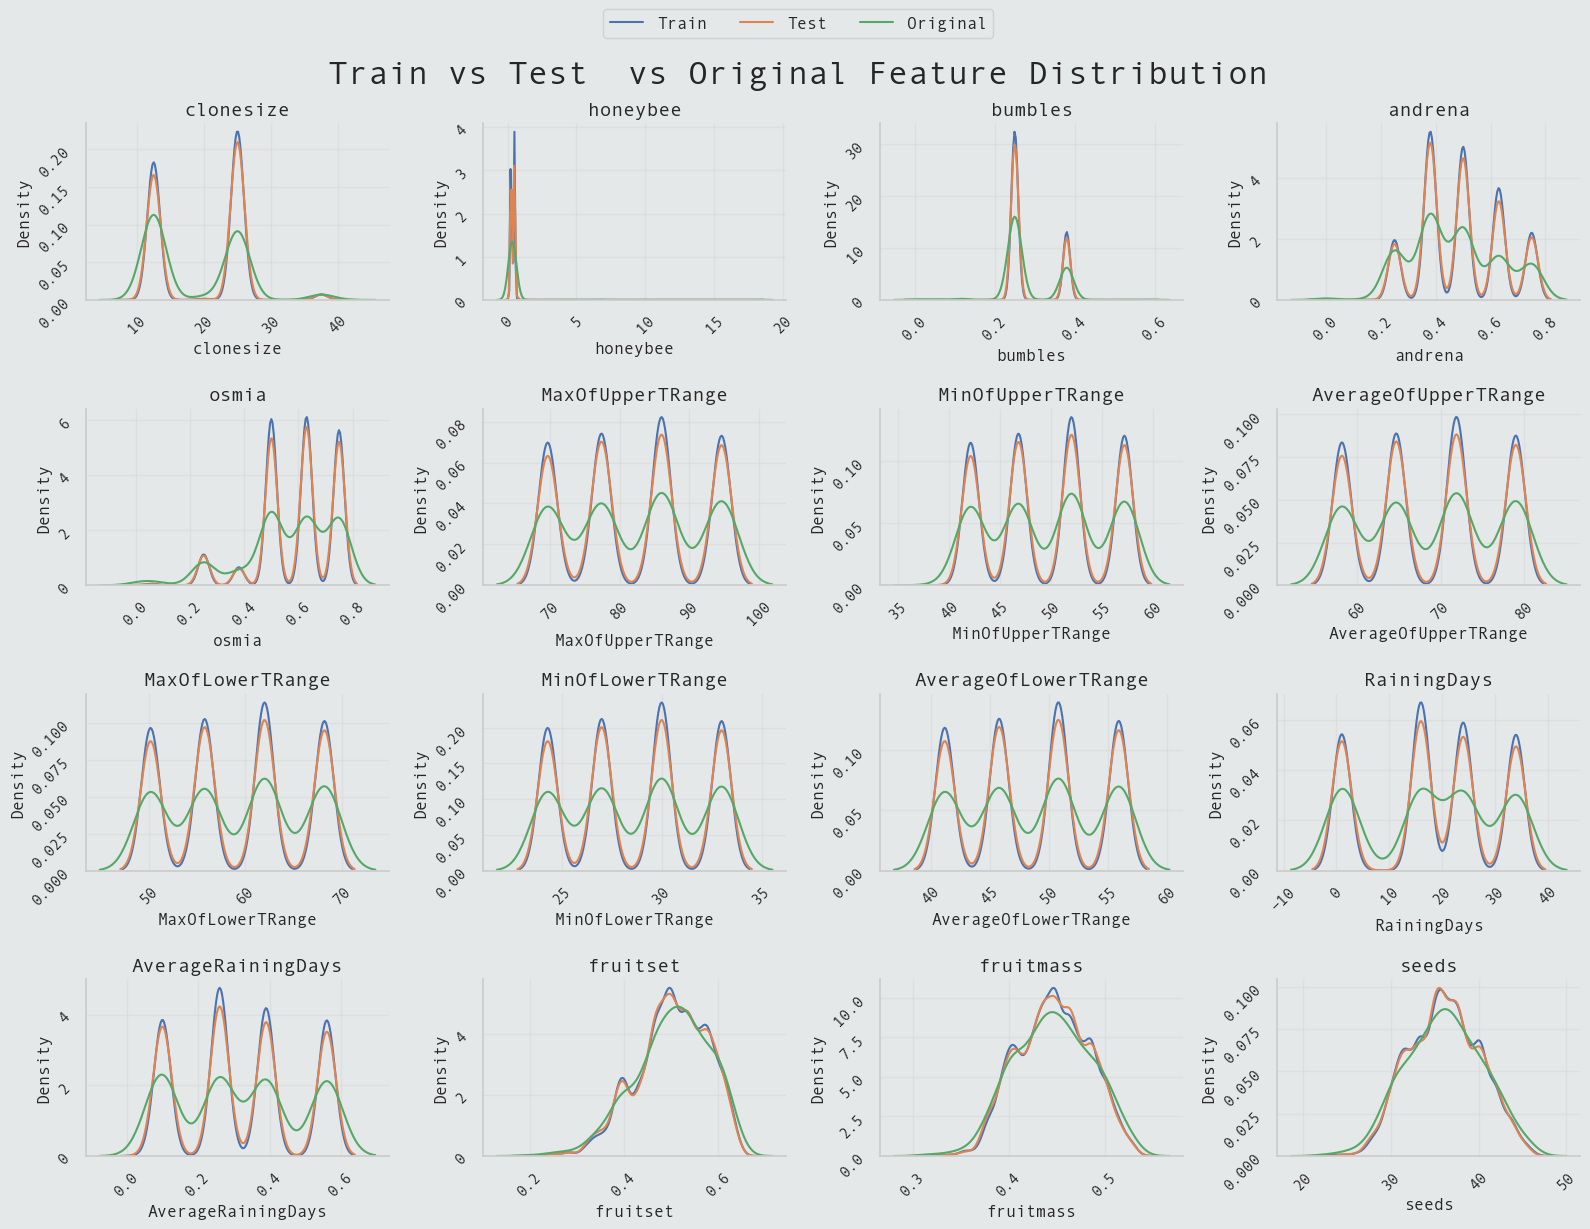

In [10]:
# Plot the KDE of each feature
figure, ax = plt.subplots(4, 4, figsize=(16, 12))
ax = ax.flatten()

# Fetch the data to plot (exclude the 'id' and 'label' columns)
for index, column_name in enumerate(train_data.columns[1:-1]):
    
    # Plot data
    sns.kdeplot(data=train_data[column_name],
                label='Train',
                ax=ax[index])
    
    sns.kdeplot(data=test_data[column_name],
                label='Test',
                ax=ax[index])
    
    sns.kdeplot(data=original_data[column_name],
                label='Original',
                ax=ax[index])
    
    ax[index].set_title(column_name, fontsize=14)
    
    ax[index].tick_params(labelrotation=45)
    
    # Retrieve legend information
    handles = ax[index].get_legend_handles_labels()[0]
    labels = ax[index].get_legend_handles_labels()[1]
    ax[index].legend().remove()

# Set the legend
figure.legend(handles, 
              labels, 
              loc='upper center', 
              bbox_to_anchor=(0.5, 1.03), 
              fontsize=12,
              ncol=3)

figure.suptitle('Train vs Test  vs Original Feature Distribution',
                fontweight='bold',
                fontsize=24)

plt.tight_layout()

### Honeybee Distribution

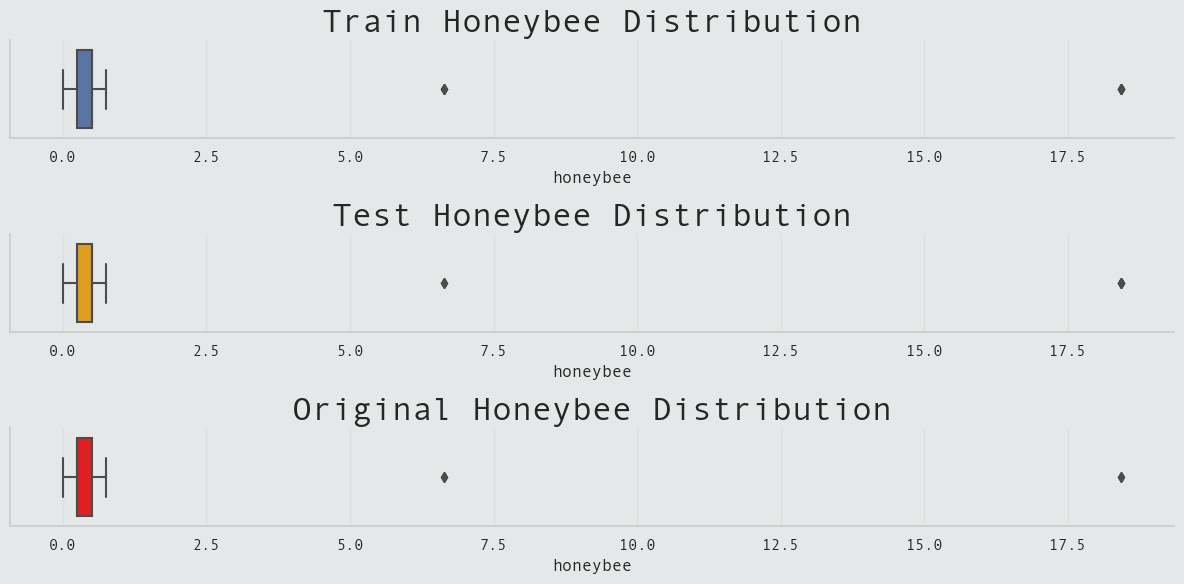

In [49]:
# Define figure and axes
figure, ax = plt.subplots(3, 1, figsize=(12, 6))
ax = ax.flatten()

# Plot the Boxplot of 'honeybee'
sns.boxplot(data=train_data,
            x='honeybee',
            ax=ax[0])

sns.boxplot(data=test_data,
            x='honeybee',
            color='orange',
            ax=ax[1])

sns.boxplot(data=original_data,
            x='honeybee',
            color='red',
            ax=ax[2])

ax[0].set_title('Train Honeybee Distribution')
ax[1].set_title('Test Honeybee Distribution')
ax[2].set_title('Original Honeybee Distribution')

plt.tight_layout()

plt.show()

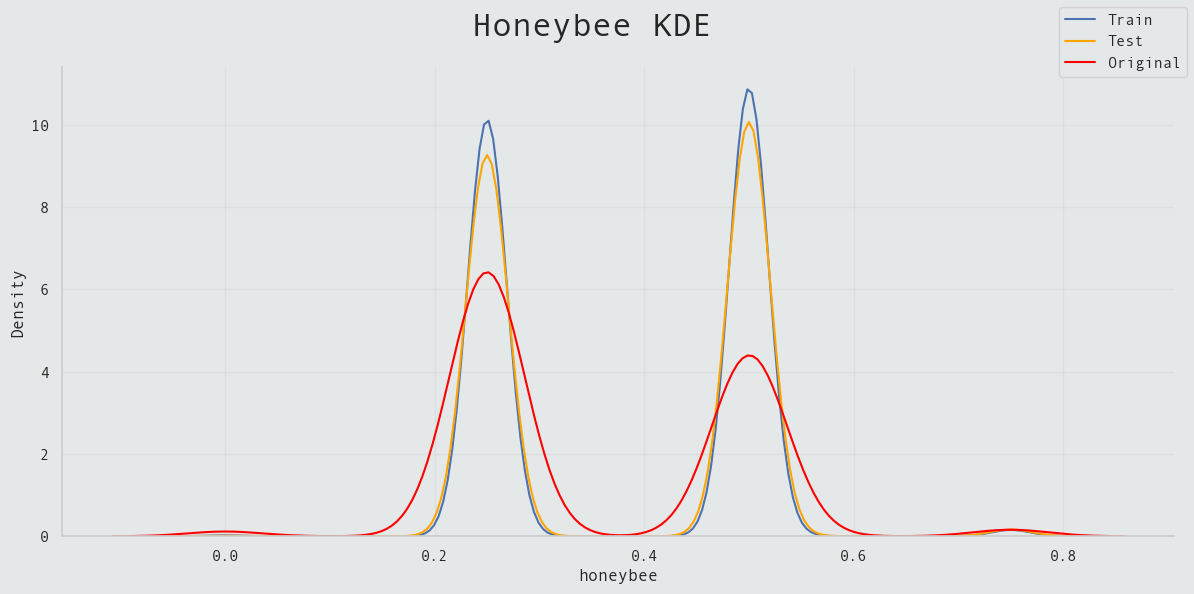

In [53]:
# Define figure and axes
figure, ax = plt.subplots(1, 1, figsize=(12, 6))

# Plot the KDEs of 'honeybee'
sns.kdeplot(data=train_data[train_data['honeybee'] < 2.5]['honeybee'],
            label='Train')

sns.kdeplot(data=test_data[test_data['honeybee'] < 2.5]['honeybee'],
            label='Test',
            color='orange')

sns.kdeplot(data=original_data[original_data['honeybee'] < 2.5]['honeybee'],
            label='Original',
            color='red')

figure.suptitle('Honeybee KDE', fontsize=24)

figure.legend()

plt.tight_layout()

plt.show()

- There are outliers in the `honeybee`
- Exclude `honeybee`, `bumbles`, `andrena` and `osmia` from Standard Scaler
- No differences between Train and Test Feature Distributions
- Temperatures have the exact same distribution
- Fruits and seeds information have almost the same distribution

## Label Distribution

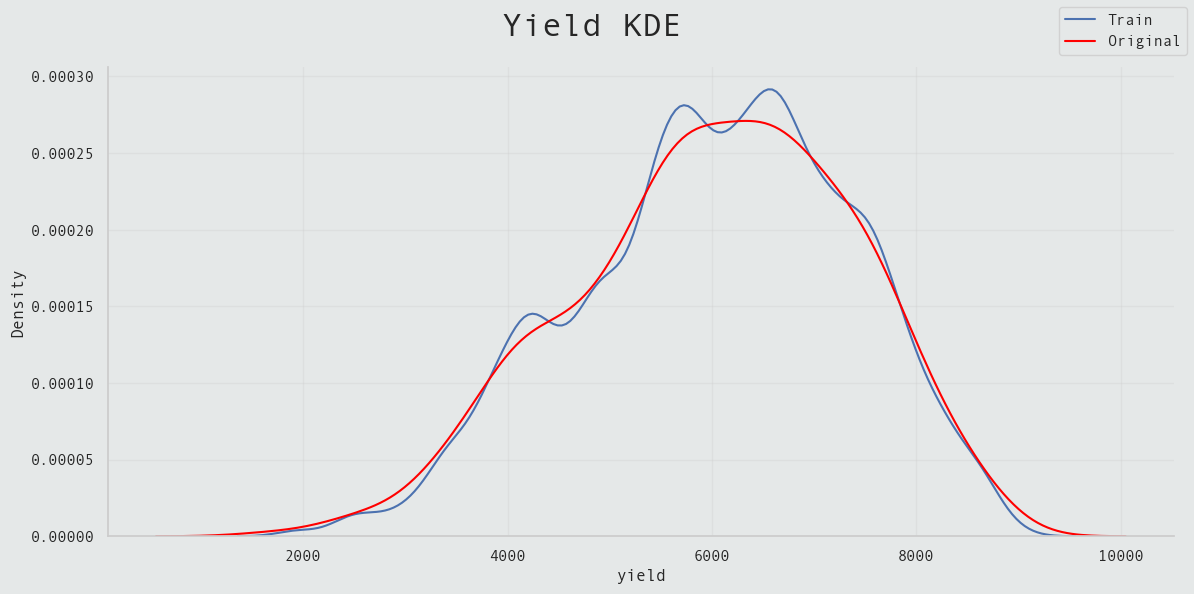

In [55]:
# Define figure and axes
figure, ax = plt.subplots(1, 1, figsize=(12, 6))

# Plot the KDE of 'yield'
sns.kdeplot(data=train_data['yield'], 
            label='Train')

sns.kdeplot(data=original_data['yield'], 
            color='red',
            label='Original')

figure.suptitle('Yield KDE', fontsize=24)

figure.legend()

plt.tight_layout()

plt.show()

### Yield vs Fruit Set vs Fruit Mass vs Seeds KDE

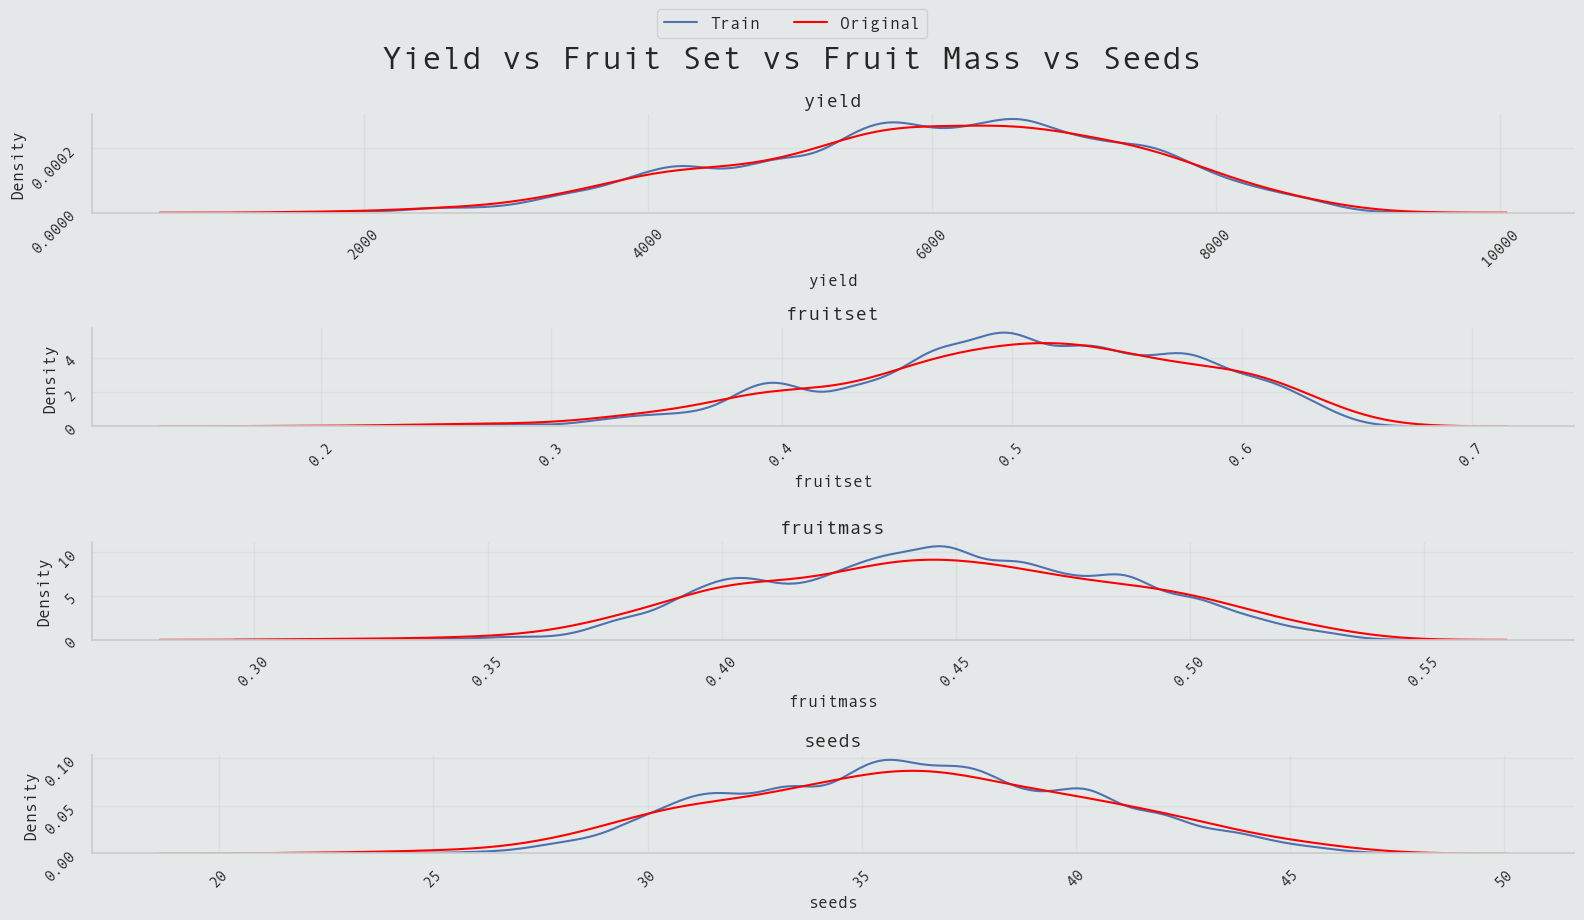

In [57]:
# Define figure and axes
figure, ax = plt.subplots(4, 1, figsize=(16, 9))
ax = ax.flatten()

for index, column_name in enumerate(train_data[['yield', 'fruitset', 'fruitmass', 'seeds']]):

    # Plot the KDEs of 'train_data' and 'original_data'
    sns.kdeplot(data=train_data[column_name], 
                label='Train', 
                ax=ax[index])

    sns.kdeplot(data=original_data[column_name], 
                label='Original', 
                color='red',
                ax=ax[index])
    
    ax[index].set_title(column_name, fontsize=14)
    
    ax[index].tick_params(labelrotation=45)
    
    # Retrieve legend information
    handles = ax[index].get_legend_handles_labels()[0]
    labels = ax[index].get_legend_handles_labels()[1]
    ax[index].legend().remove()

# Set the legend
figure.legend(handles, 
              labels, 
              loc='upper center', 
              bbox_to_anchor=(0.5, 1.03), 
              fontsize=12,
              ncol=3)

figure.suptitle('Yield vs Fruit Set vs Fruit Mass vs Seeds',
                fontweight='bold',
                fontsize=24)

plt.tight_layout()

The following features have almost the same distribution as the label:
- `fruitset`    
- `fruitmass`
- `seeds`

## Pearson Correlation

In [15]:
# Compute the correlation matrix
correlation_matrix = train_data.iloc[:, 1:].corr()

In [16]:
# Generate a mask for the upper triangle
correlation_mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

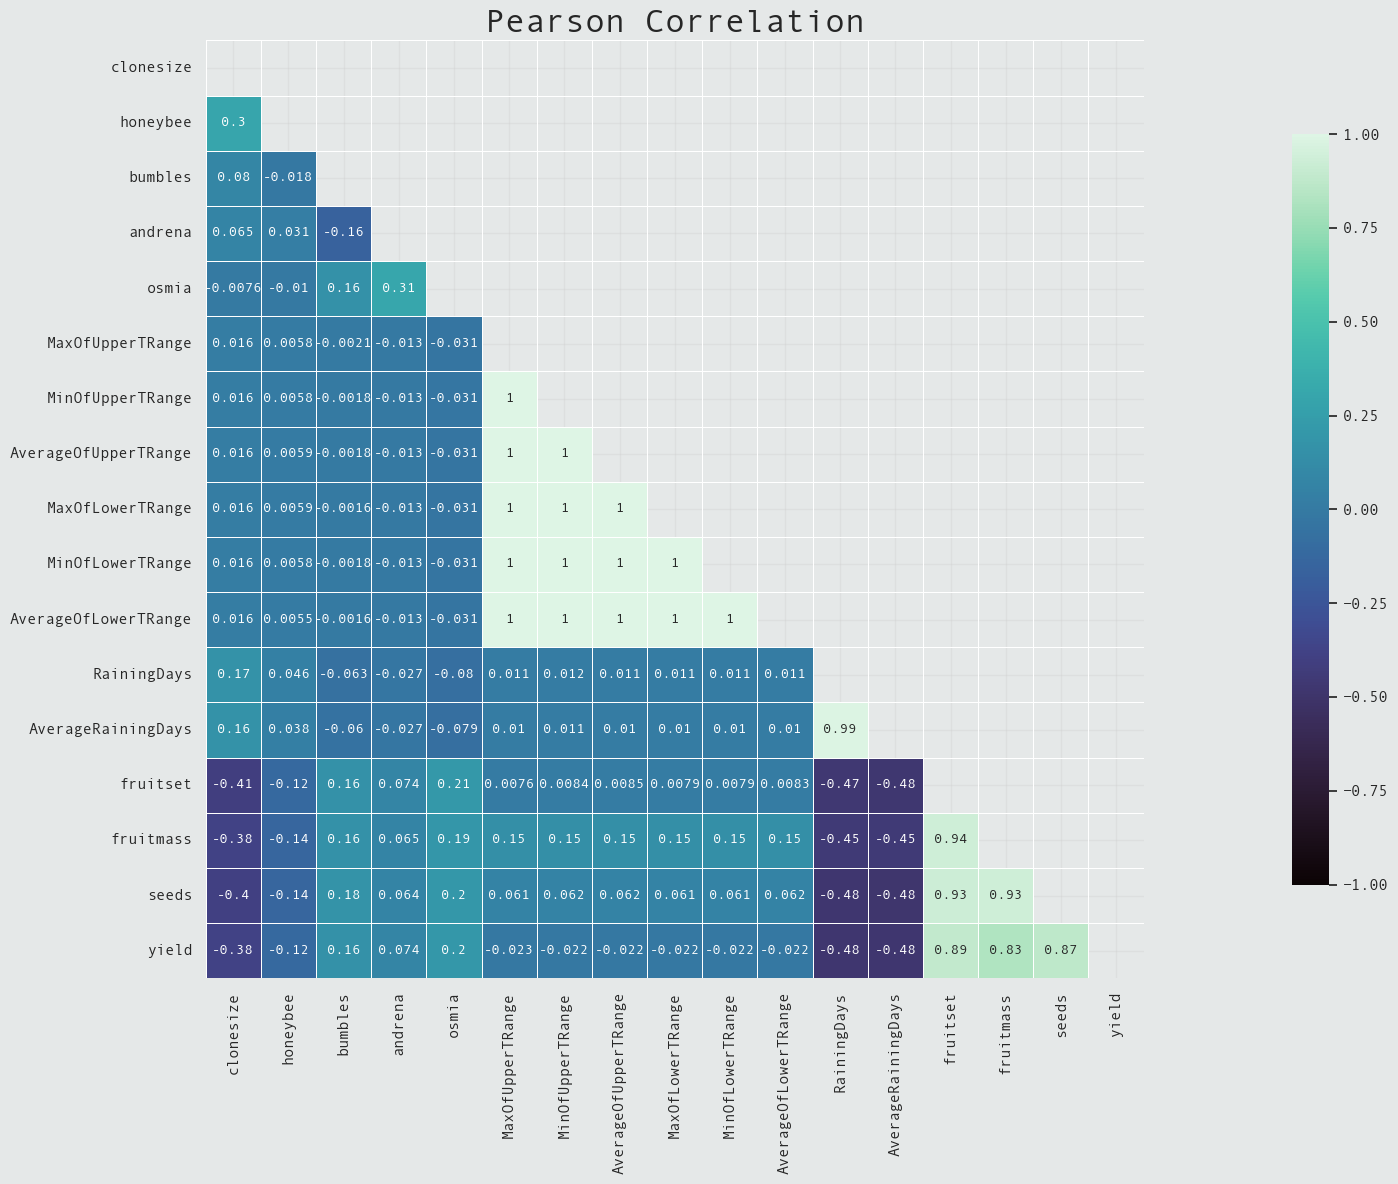

In [17]:
# Define figure and axis
figure, ax = plt.subplots(figsize=(30, 12))

# Plot the correlation matrix
sns.heatmap(correlation_matrix, 
            mask=correlation_mask, 
            cmap='mako',
            vmax=1.0, 
            vmin=-1.0, 
            center=0, 
            square=True, 
            linewidths=.5, 
            annot=True,
            annot_kws={'fontsize': 10},
            cbar_kws={"shrink":.8, 'orientation':'vertical'})

# Set title
ax.set_title('Pearson Correlation', 
             fontsize=24, 
             fontweight='bold')

plt.tight_layout()

plt.show()

- There an important correlation between `clonesize` and `honeybee`
- There is another confirmation that`fruitset`, `fruitmass` and `seeds` are strongly from `yield`. However, the strong correlation and the almost same distribution might mean that those three features are retrieved in the exact same moment in which also the yield is retrieved. They might be not available in a previous time and thus not useful in case of a previous prediction time.
- All the temperatures are duplicated features. Just keep `MaxOfUpperTRange`.
- The features `AverageRainingDays` and `RainingDays` are identical. Keep only `AverageRainingDays`

## Pairplots

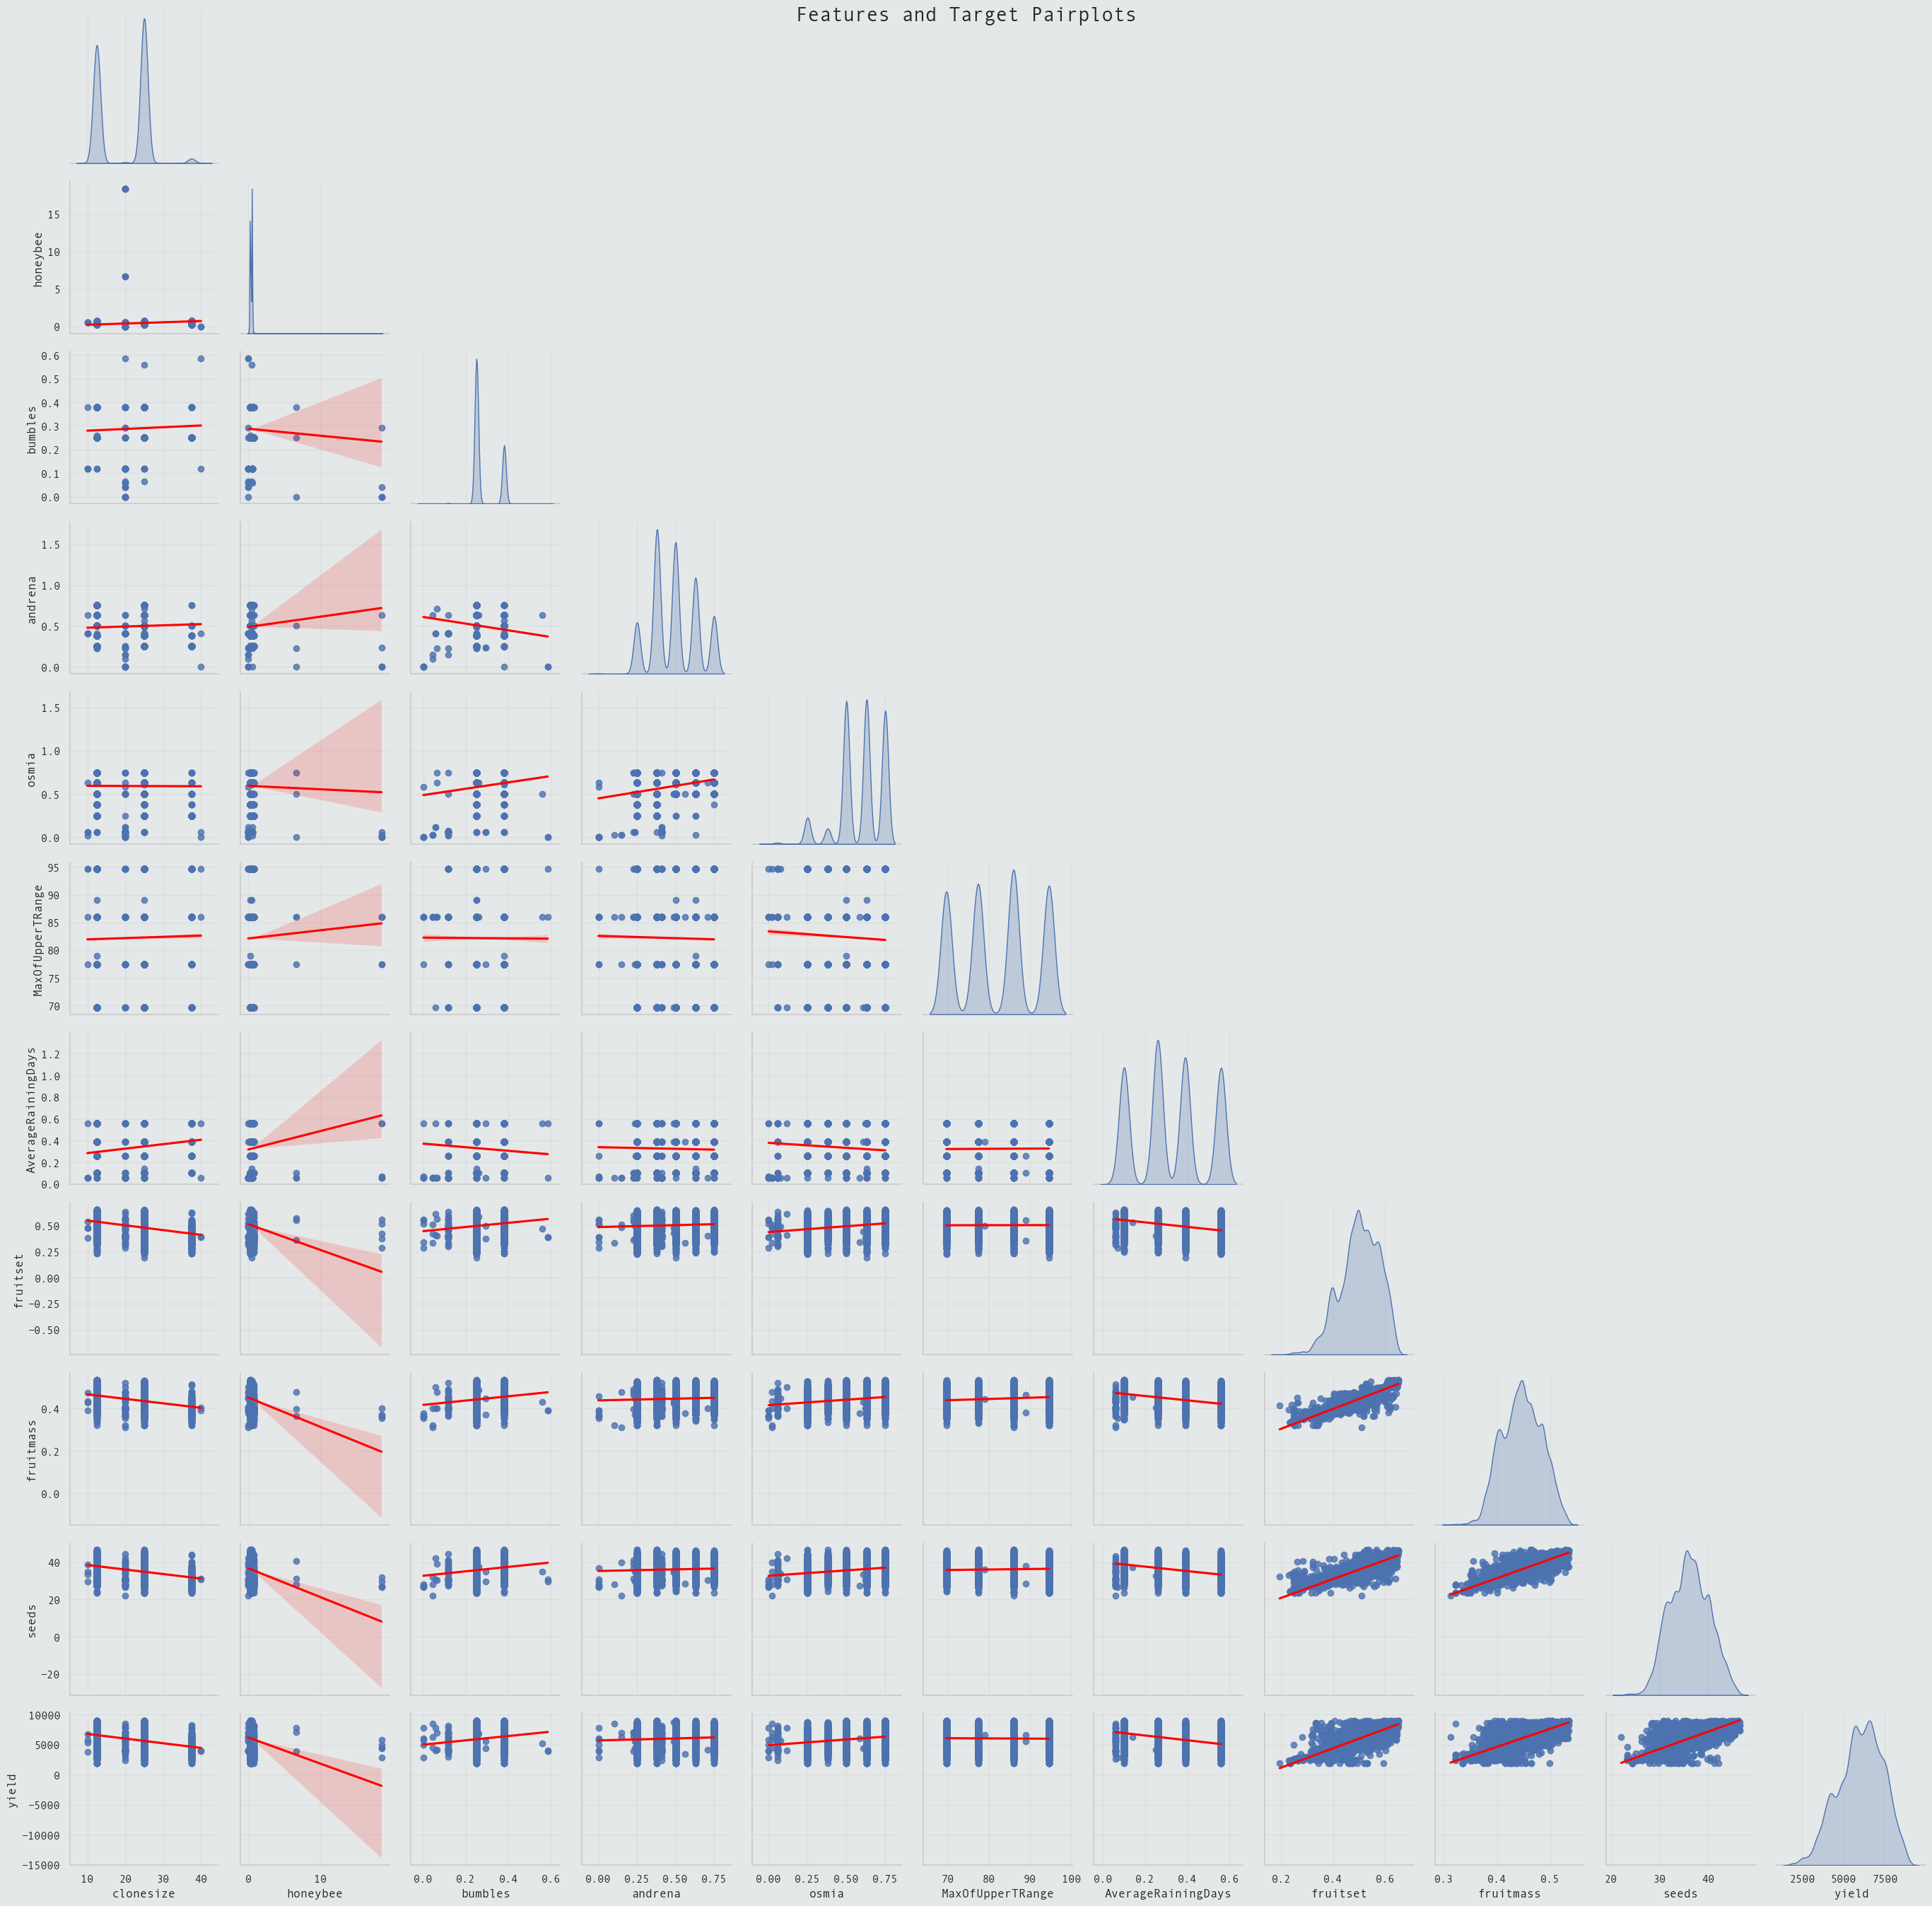

In [18]:
# Plot the Pairplot between features and the target
sns.pairplot(train_data[['clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia', 'MaxOfUpperTRange', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds', 'yield']],
             kind="reg",
             diag_kind='kde',
             plot_kws={'line_kws':{'color':'red'}},
             corner=True)

# Set title plot
plt.suptitle('Features and Target Pairplots', 
             fontsize=20, 
             fontweight='bold')

plt.tight_layout()

plt.show()

## Conclusions

- No null values
- Outlisers in `honeybee`
- No differences between Train and Test Feature Distributions
- The following features have almost the same distribution as the label:
    - `fruitset`    
    - `fruitmass`
    - `seeds`
- There is an important correlation between `clonesize` and `honeybee`
- All the temperatures are duplicated features. Just keep `MaxOfUpperTRange`.
- The features `AverageRainingDays` and `RainingDays` are identical. Keep only `AverageRainingDays`

# Data Preparation

## Feature Engineering

In [19]:
def compute_engineered_features(data: pd.DataFrame) -> pd.DataFrame:
    """
    Create a pre-defined set of engineered feature to the input DataFrame
    
    Args:
        data Pandas.DataFrame input
    
    Returns:
        data Pandas.DataFrame with additional engineered features
    """
    
    # Create a feature `fruitset per fruitmass`
    data['fruitset per fruitmass'] = data['fruitset'] * data['fruitmass']
    
    # Create a feature `fruitset per seeds`
    data['fruitset per seeds'] = data['fruitset'] * data['seeds']
    
    # Create a feature `fruitmass per seeds`
    data['fruitmass per seeds'] = data['fruitmass'] * data['seeds']
    
    # Create a feature `clonesize per honeybee`
    data['clonesize per honeybee'] = data['clonesize'] * data['honeybee']
    
    return data

In [20]:
# Apply the feature engineering
train_data_engineered = compute_engineered_features(train_data)
test_data_engineered = compute_engineered_features(test_data)
original_data_engineered = compute_engineered_features(original_data)

## Features and Labels Definition

In [21]:
# Define features and labels
numerical_features = ['clonesize', 
                      'honeybee', 
                      'bumbles', 
                      'andrena', 
                      'osmia', 
                      'MaxOfUpperTRange', 
                      'AverageRainingDays', 
                      'fruitset', 
                      'fruitmass', 
                      'seeds']

numerical_engineered_featuers = ['fruitset per fruitmass',
                                 'fruitset per seeds', 
                                 'fruitmass per seeds', 
                                 'clonesize per honeybee']

categorical_features = []

categorical_engineered_features = []

features = numerical_features + numerical_engineered_featuers + categorical_features + categorical_engineered_features

labels = ['yield']

## Numerical Features Preprocessing Pipeline

In [22]:
# Numerical features pipeline
numerical_features_pipeline = Pipeline(steps=[
    ('numerical_scaler', StandardScaler())
])

## Bundle Data Preprocessing Steps

In [23]:
# Bunlde data preprocessing steps
data_preprocessor = ColumnTransformer(
    transformers=[
        ('numerical_preprocessing', numerical_features_pipeline, numerical_features + numerical_engineered_featuers)
    ])

# Train & Test Split

In [24]:
# Define X and y for the training set
if include_original_data:
    X = pd.concat([train_data_engineered[features], original_data_engineered[features]], axis=0)
    y = pd.concat([train_data_engineered[labels], original_data_engineered[labels]], axis=0)
else:
    X = train_data_engineered[features]
    y = train_data_engineered[labels]

In [25]:
# Split training data into train and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=108)

# Model Training

In [26]:
# Set MLflow Experiment
mlflow_experiment_name = 'Wild Blueberry Yield'

# Create experiment or retrieve already existing experiment
try:
    mlflow_experiment_id = mlflow.create_experiment(name=mlflow_experiment_name)
except Exception as e:
    mlflow_experiment_id = mlflow.get_experiment_by_name(mlflow_experiment_name).experiment_id

In [27]:
# Define trained models
models = {}

In [28]:
# Define the used metrics
metrics = ['RMSE', 'MSE', 'MAE', 'MAPE', 'R2 Score']

In [29]:
# Initialize DataFrame of model performance
performance = pd.DataFrame(columns=metrics)

## Linear Regression

In [30]:
%%time

# Start MLflow Run
with mlflow.start_run(experiment_id=mlflow_experiment_id, 
                      run_name='Linear Regression'):
    # Define the model
    model_lr = LinearRegression()

    # Define the pipeline
    pipe_lr = Pipeline([
        ('data_preprocessing', data_preprocessor),
        ('linear_regression', model_lr)
    ])
    
    # Train the pipeline
    pipe_lr.fit(X_train, 
                y_train)

    # Get predictions
    predictions_lr = pipe_lr.predict(X_test)

    # Compute metrics
    rmse_lr = round(mean_squared_error(y_test, predictions_lr) ** 0.5, 2)
    mse_lr = round(mean_squared_error(y_test, predictions_lr), 2)
    mae_lr = round(mean_absolute_error(y_test, predictions_lr), 2)
    mape_lr = round(mean_absolute_percentage_error(y_test, predictions_lr), 2)
    r2_score_lr = round(r2_score(y_test, predictions_lr), 2)

    print('RMSE: {}'.format(rmse_lr))
    print('MSE: {}'.format(mse_lr))
    print('MAE: {}'.format(mae_lr))
    print('MAPE: {}'.format(mape_lr))
    print('R2 Score: {}'.format(r2_score_lr))
    print('\n')
    
    # Log model's evaluation metrics
    mlflow.log_metrics({'RMSE': rmse_lr, 
                        'MSE': mse_lr, 
                        'MAE': mae_lr, 
                        'MAPE': mape_lr, 
                        'R2': r2_score_lr})
    
    # Log model's features
    mlflow.log_params({'Features': features, 
                       'Include Original Dataset': include_original_data})

RMSE: 547.75
MSE: 300030.86
MAE: 353.08
MAPE: 0.06
R2 Score: 0.84


CPU times: user 133 ms, sys: 94.5 ms, total: 227 ms
Wall time: 195 ms


In [31]:
# Update 'performance' DataFrame
performance.loc['Logistic Regression'] = [rmse_lr, mse_lr, mae_lr, mape_lr, r2_score_lr]

In [32]:
# Add the trained model to the list of models
models['Linear Regression'] = pipe_lr

## XGBoost

In [33]:
# XGBoost Hyperparameters
hyperparameter_xgb = {
    'n_estimators': 100,
    'max_depth': 3,
    'learning_rate': 0.1
}

In [34]:
%%time

# Start MLflow Run
with mlflow.start_run(experiment_id=mlflow_experiment_id, 
                      run_name='XGBoost'):
    # Define the model
    model_xgb = XGBRegressor(**hyperparameter_xgb)

    # Define the pipeline
    pipe_xgb = Pipeline([
        ('data_preprocessing', data_preprocessor),
        ('xgboost', model_xgb)
    ])

    # Train the pipeline
    pipe_xgb.fit(X_train, 
                y_train)

    # Get predictions
    predictions_xgb = pipe_xgb.predict(X_test)

    # Compute metrics
    rmse_xgb = round(mean_squared_error(y_test, predictions_xgb) ** 0.5, 2)
    mse_xgb = round(mean_squared_error(y_test, predictions_xgb), 2)
    mae_xgb = round(mean_absolute_error(y_test, predictions_xgb), 2)
    mape_xgb = round(mean_absolute_percentage_error(y_test, predictions_xgb), 2)
    r2_score_xgb = round(r2_score(y_test, predictions_xgb), 2)

    print('RMSE: {}'.format(rmse_xgb))
    print('MSE: {}'.format(mse_xgb))
    print('MAE: {}'.format(mae_xgb))
    print('MAPE: {}'.format(mape_xgb))
    print('R2 Score: {}'.format(r2_score_xgb))
    print('\n')
    
    # Log model's evaluation metrics
    mlflow.log_metrics({'RMSE': rmse_xgb, 
                        'MSE': mse_xgb, 
                        'MAE': mae_xgb, 
                        'MAPE': mape_xgb, 
                        'R2': r2_score_xgb})
    
    # Log model's features
    mlflow.log_params({'Features': features, 
                       'Include Original Dataset': include_original_data})

RMSE: 529.62
MSE: 280498.25
MAE: 336.96
MAPE: 0.06
R2 Score: 0.85


CPU times: user 2.21 s, sys: 197 ms, total: 2.4 s
Wall time: 452 ms


In [35]:
# Update 'performance' DataFrame
performance.loc['XGBoost'] = [rmse_xgb, mse_xgb, mae_xgb, mape_xgb, r2_score_xgb]

In [36]:
# Add the trained model to the list of models
models['XGBoost'] = pipe_xgb

# Model Explanability

## Model Comparison

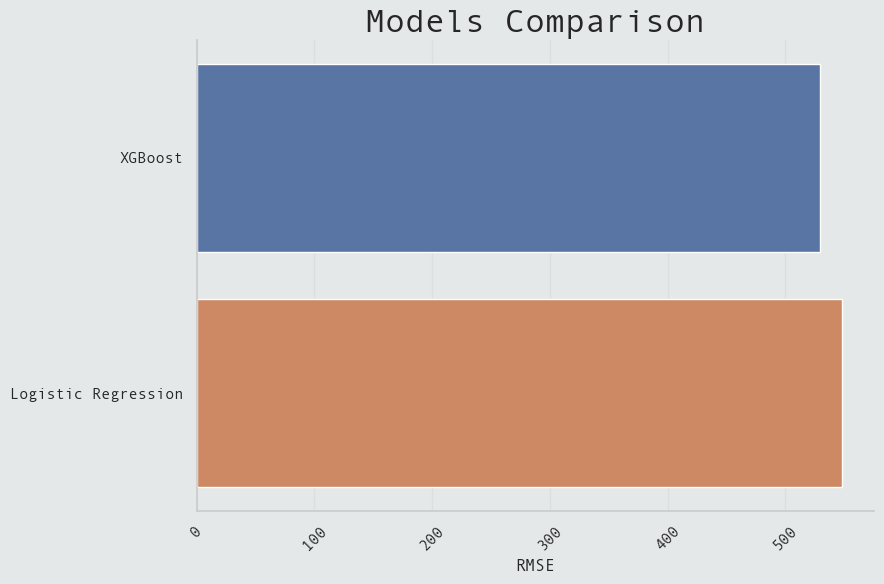

In [37]:
# Sort dataframe by the metric
performance.sort_values('RMSE', inplace=True)

# Create figure
figure = plt.figure(tight_layout=True, figsize=(9, 6))

# Plot models' metrics
ax = sns.barplot(data=performance, 
                 x='RMSE', 
                 y=performance.index.tolist())

# Set title
ax.set_title('Models Comparison', 
             fontsize=24)

# Set tick rotation
plt.xticks(rotation=45)

# Plot with tight layout
plt.tight_layout()

- XGBoost performs slightly better in terms of RMSE with respect to the Logistic Regression model

## Feature Importance

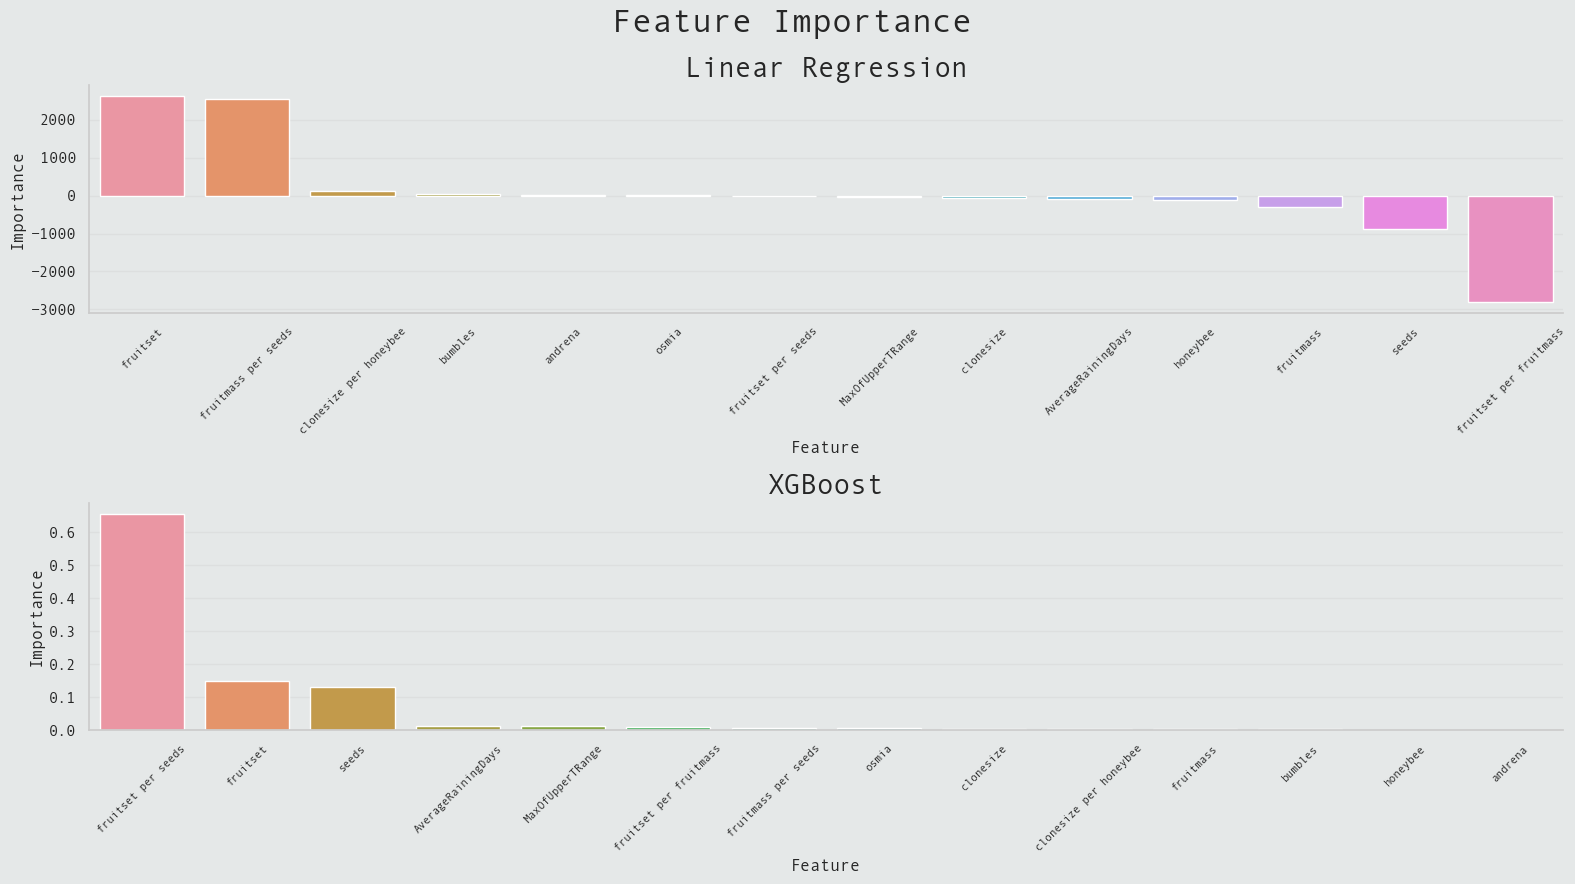

In [38]:
# Define figure and axes
figure, ax = plt.subplots(2, 1, figsize=(16, 9))
ax = ax.flatten()

# Fetch all the trained models
for index, model_name in enumerate(models.keys()):
    
    # Retrieve feature names
    feature_names = models[model_name].feature_names_in_
    
    # Retrieve pipeline model's step name
    pipe_model_step_name = list(models[model_name].named_steps.keys())[-1]
    
    # Retrieve feature importances values
    try:
        # ree-based models
        feautre_importance_values = models[model_name].named_steps[pipe_model_step_name].feature_importances_
    except:
        # Regression-based models
        feautre_importance_values = models[model_name].named_steps[pipe_model_step_name].coef_.reshape(-1,)
        
    
    
    # Compute the feature importance
    feature_importance = sorted(list(zip(feature_names,
                                         feautre_importance_values)),
                                key=lambda x: x[1], reverse=True)

    # Transform it into a DataFrame
    feature_importance_df = pd.DataFrame(feature_importance,
                                         columns= ['Feature', 'Importance'])    
    
    # Plot the feature importance
    sns.barplot(data=feature_importance_df,
               x='Feature',
               y='Importance', 
               ax=ax[index])

    # Set title
    ax[index].set_title(model_name, 
                 fontsize=20, 
                 fontweight='bold')

    # Refine x labels
    ax[index].set_xticklabels(feature_importance_df['Feature'],
                              fontsize=8,
                              rotation=45)

# Define figure title
figure.suptitle('Feature Importance',
                fontweight='bold',
                fontsize=24)

# Plot with tight layout
plt.tight_layout()

- Feature importance in XGBoost shows a reasonable relationship between two primary features: `fruitset` and `seeds`

## Learning Curves

In [39]:
# Define Learning Curves Display parameters
learning_curves_display_paramters = {
    'X': X,
    'y': y,
    'cv': ShuffleSplit(n_splits=10, test_size=0.3, random_state=108),
    'train_sizes': np.linspace(0.1, 1.0, 10),
    'scoring': 'neg_root_mean_squared_error',
    'negate_score': True,
    'score_name': 'RMSE',
    'score_type': 'both',
    'verbose': 0,
    'line_kw': {'marker': 'o'},
    'std_display_style': 'fill_between',
}

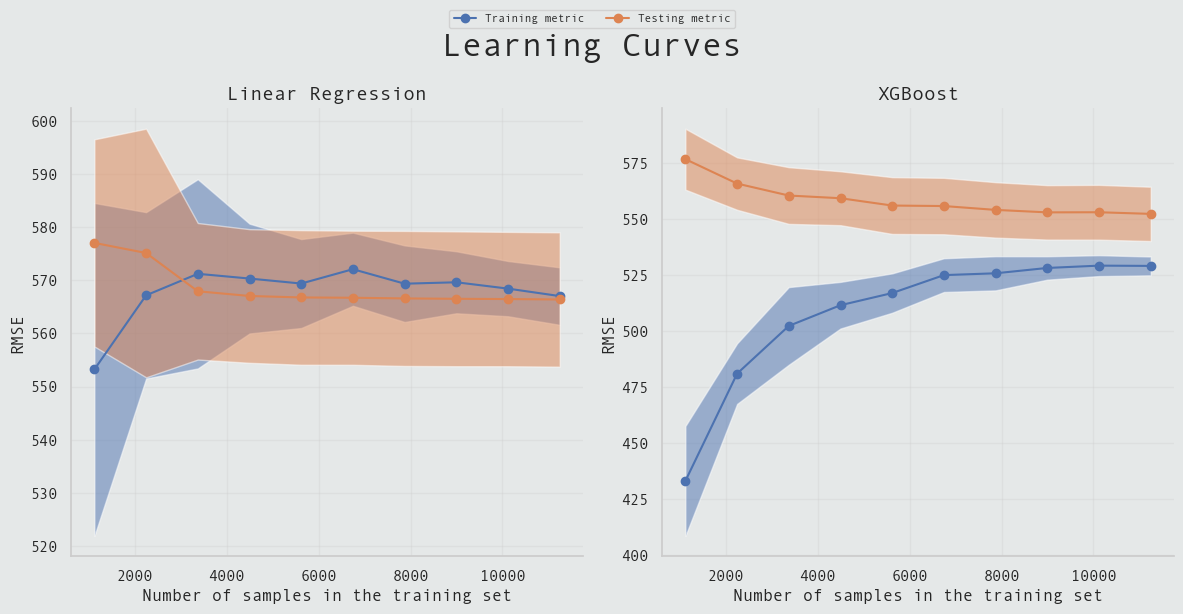

In [40]:
# Define figure and axes
figure, ax = plt.subplots(1, 2, figsize=(12, 6))
ax = ax.flatten()

# Fetch all the trained models
for index, model_name in enumerate(models.keys()):

    # Plot the Learning Curve
    LearningCurveDisplay.from_estimator(models[model_name], 
                                        **learning_curves_display_paramters,
                                        ax=ax[index])
    
    # Retrieve legend information
    handles = ax[index].get_legend_handles_labels()[0]
    labels = ax[index].get_legend_handles_labels()[1]
    ax[index].legend().remove()
    
    # Set the title
    ax[index].set_title(model_name, fontsize=14)
    
# Set the legend
figure.legend(handles, 
              labels, 
              loc='upper center', 
              bbox_to_anchor=(0.5, 1.03), 
              fontsize=8,
              ncol=2)

# Define figure title
figure.suptitle('Learning Curves',
                fontweight='bold',
                fontsize=24)
    
# Plot with tight layout
plt.tight_layout()

From the Learning Curves it is possible to see that XGBoost is learning better from more data with respect to Linear Regression, which seems to be quite randomic.

## Residuals

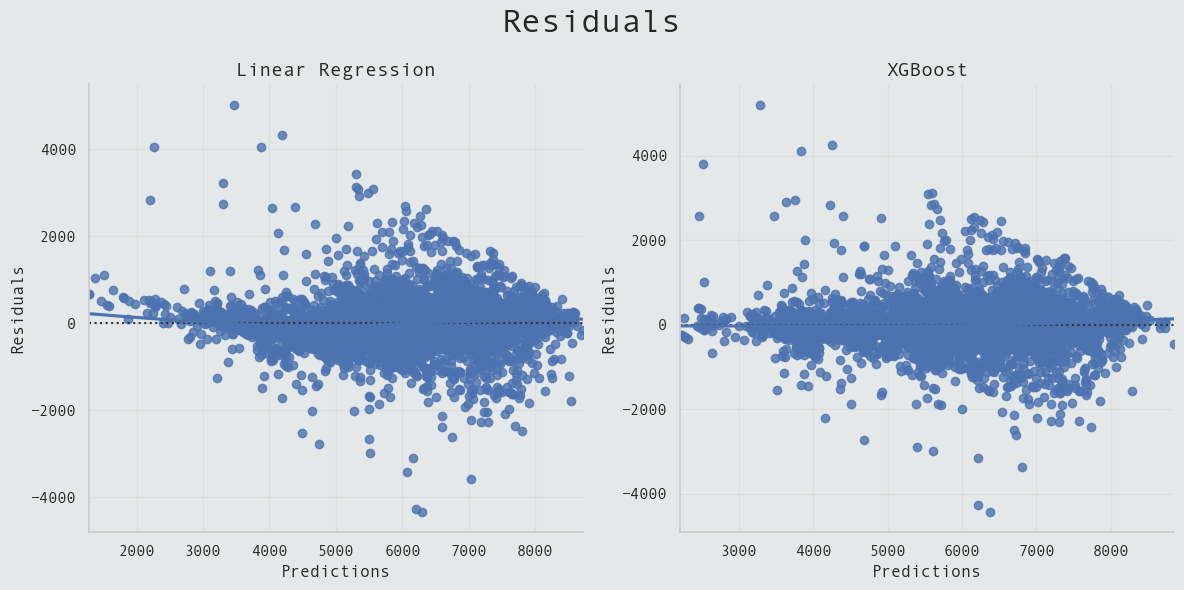

In [41]:
# Define figure and axes
figure, ax = plt.subplots(1, 2, figsize=(12, 6))
ax = ax.flatten()

# Fetch all the trained models
for index, model_name in enumerate(models.keys()):
    
    # Compute the predictions for the test set
    predictions = models[model_name].predict(X_test)
    
    # Reshape predictions
    predictions = predictions.reshape(-1, 1)
    
    # Compute the residuals
    residuals = y_test - predictions
    
    # Create the Pandas DataFrame
    residuals_df = pd.DataFrame({'Residuals': residuals.to_numpy().reshape(-1,), 
                                 'Predictions': predictions.reshape(-1,)})
    
    # Plot the residuals
    sns.residplot(x='Predictions', 
                  y='Residuals',
                  data=residuals_df, 
                  ax=ax[index],
                  lowess=True)

    # Set the title
    ax[index].set_title(model_name, fontsize=14)

# Define figure title
figure.suptitle('Residuals',
                fontweight='bold',
                fontsize=24)

# Plot with tight layout
plt.tight_layout()

- Sparsity of the residuals from the XGBoost model seems a bit less

## Q-Q Plots

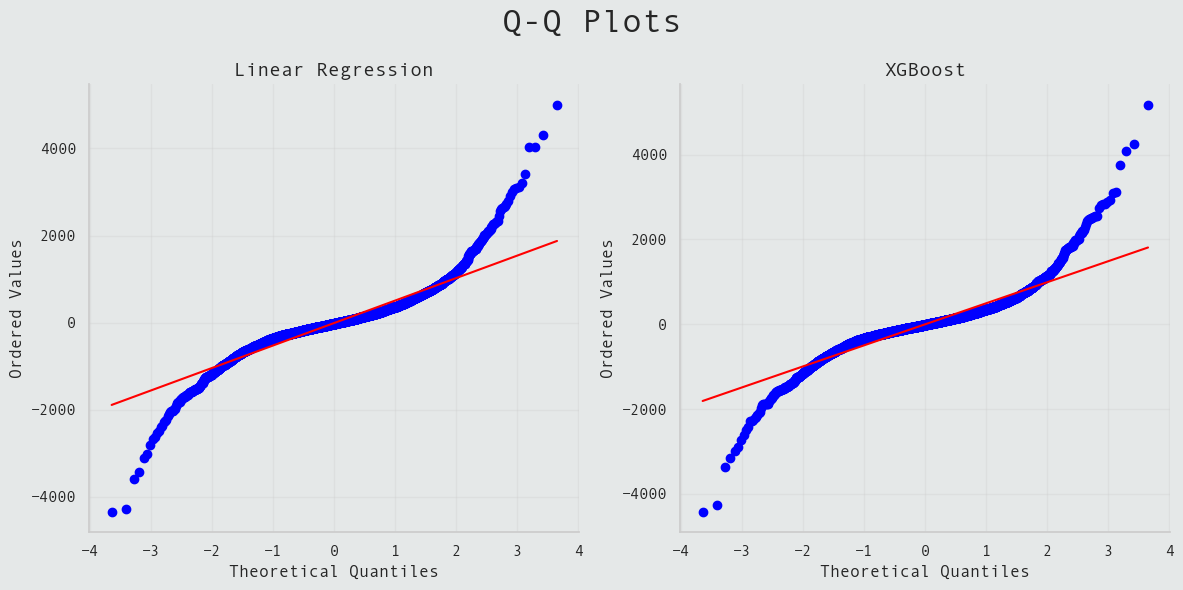

In [42]:
# Define figure and axes
figure, ax = plt.subplots(1, 2, figsize=(12, 6))
ax = ax.flatten()

# Fetch all the trained models
for index, model_name in enumerate(models.keys()):
    
    # Compute the predictions for the test set
    predictions = models[model_name].predict(X_test)
    
    # Reshape predictions
    predictions = predictions.reshape(-1, 1)
    
    # Compute the residuals
    residuals = y_test - predictions
    
    # Generate a QQ plot
    stats.probplot(residuals.to_numpy().reshape(-1,), 
                   plot=ax[index])
    
    ax[index].set_xlabel('Theoretical Quantiles')

    # Set the title
    ax[index].set_title(model_name, fontsize=14)
    
    
figure.suptitle('Q-Q Plots',
                fontweight='bold',
                fontsize=24)

plt.tight_layout()

No significant difference.

## Model Diagnostic

# Submission

In [43]:
# Generate predictions with test set
submission_predictions = pipe_xgb.predict(test_data_engineered)

In [44]:
# Create submission DataFrame
submission = pd.DataFrame({'id': test_data.id, 'yield': submission_predictions})

In [45]:
# Write CSV File
submission.to_csv('./submission.csv', index=False)